<img src="https://github.com/insaid2018/Term-1/blob/master/Images/INSAID_Full%20Logo.png?raw=true" width="240" height="360" />

# Model evaluation - Recall Case

## Table of Content

1. [Problem Statement](#section1)<br>
2. [Data Loading and Description](#section2)<br>
3. [Exploratory Data Analysis](#section3)<br>
4. [Random Forest Classifier](#section4)<br>
5. [Model evaluation](#section5)<br>
    - 5.1 [Model evaluation using accuracy score](#section501)<br>
    - 5.2 [Model Evaluation using confusion matrix](#section502)<br>
    - 5.3 [Model evaluation using precision score](#section503)<br>
    - 5.4 [Model evaluation using recall score](#section504)<br>
    - 5.5 [Model evaluation using f1_score](#section505)<br>
    - 5.6 [Model evaluation using ROC_AUC curve](#section506)<br>
    - 5.7 [Choosing better model using recall score](#section507)<br>

<a id = section1></a>

## 1. Problem Statement

Given the __credit card transaction__ dataset, make a model to predict transactions are fradulent or not using random forest algorithm. Evaluate the model using possible __model evaluation techniques__. 

<a id = section2></a>

## 2. Data Loading and Description

The datasets contains _transactions made by credit cards in September 2013 by european cardholders_. This dataset presents transactions that occurred in two days, where we have __38 frauds__ out of __10000 transactions__. The dataset is _highly unbalanced_, the positive class (frauds) account for __0.0038%__ of all transactions.

It contains only __numerical input variables__ which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are '__Time__' and '__Amount__'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature '__Class__' is the response variable and it takes value __1__ in case of __fraud__ and __0 otherwise__. 

- __False Positive__ are the cases where the we would predict that the transaction would be fraudulent whereas actually it wont be.
- __False Negative__ would be the case when we would predict that transaction is not fradulent but actually it would be fraudulent.

Now, there's a need to reduce both false positive and false negative, but simultaneous reduction of these two is not possible. So, we need to trade off one of them. Thinking from the perspective of the company, __minimising False negative__ cases is of prime concern as _letting go fradulent transaction would lead to monetary loss and customer dissatisfaction_ whereas classifying non-fradulent transactions as fraud would just involve transaction validation by contacting the customer via call or email, and it wouldnt cost much to the company as compared to the case where there can be huge monetary loss due to fraudulent transaction.  

__Importing Packages__

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

#### Importing the Dataset

In [2]:
fraud = pd.read_csv('https://raw.githubusercontent.com/insaid2018/Term-2/master/CaseStudy/credit_fraud.csv')
fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<a id = section3></a>

## 3. Exploratory Data Analysis

#### Check the shape of the dataset

In [3]:
fraud.shape

(10000, 31)

#### Check the columns present in the dataset

In [4]:
fraud.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
fraud.Class.value_counts()

0    9962
1      38
Name: Class, dtype: int64

#### Check the descriptive statistics of the dataset

In [6]:
fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5966.033400,-0.241862,0.281949,0.906270,0.264148,-0.046398,0.133108,-0.071689,-0.064778,0.802224,...,-0.051990,-0.152671,-0.033268,0.021335,0.087146,0.108140,0.005518,0.002915,63.030188,0.00380
std,4473.403739,1.521679,1.308139,1.159154,1.441235,1.182935,1.307311,1.077430,1.259064,1.155198,...,0.913811,0.631083,0.487814,0.594430,0.428171,0.562793,0.410868,0.266247,184.486158,0.06153
min,0.000000,-27.670569,-34.607649,-15.496222,-4.657545,-32.092129,-23.496714,-26.548144,-23.632502,-6.329801,...,-11.468435,-8.527145,-15.144340,-2.512377,-2.577363,-1.338556,-7.976100,-3.509250,0.000000,0.00000
25%,2072.750000,-1.013283,-0.208342,0.412799,-0.614424,-0.643390,-0.629934,-0.542336,-0.190747,0.070868,...,-0.268120,-0.549638,-0.174120,-0.327817,-0.158137,-0.327974,-0.084489,-0.015753,5.000000,0.00000
50%,4563.500000,-0.372799,0.288524,0.944361,0.219861,-0.152769,-0.152566,-0.055585,0.012865,0.805275,...,-0.123273,-0.136746,-0.045794,0.079976,0.121001,0.042865,-0.004568,0.015897,15.950000,0.00000
75%,10233.250000,1.150864,0.901879,1.602903,1.125666,0.371081,0.505357,0.476280,0.274533,1.506299,...,0.032707,0.247490,0.081665,0.410877,0.359058,0.476394,0.120811,0.077182,50.960000,0.00000
max,15012.000000,1.960497,8.636214,4.101716,10.463020,34.099309,21.393069,34.303177,5.060381,10.392889,...,22.588989,4.534454,13.876221,3.200201,5.525093,3.517346,8.254376,4.860769,7712.430000,1.00000


#### Check the info of the dataset

In [7]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
Time      10000 non-null int64
V1        10000 non-null float64
V2        10000 non-null float64
V3        10000 non-null float64
V4        10000 non-null float64
V5        10000 non-null float64
V6        10000 non-null float64
V7        10000 non-null float64
V8        10000 non-null float64
V9        10000 non-null float64
V10       10000 non-null float64
V11       10000 non-null float64
V12       10000 non-null float64
V13       10000 non-null float64
V14       10000 non-null float64
V15       10000 non-null float64
V16       10000 non-null float64
V17       10000 non-null float64
V18       10000 non-null float64
V19       10000 non-null float64
V20       10000 non-null float64
V21       10000 non-null float64
V22       10000 non-null float64
V23       10000 non-null float64
V24       10000 non-null float64
V25       10000 non-null float64
V26       10000 non-null float64
V27

#### Check the missing values present in the dataset. 

In [8]:
fraud.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

#### Using RobustScaler, scale the variables 'Time' and 'Amount'.
- Please refer to the link of RobustScalar - http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

In [9]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

fraud['scaled_amount'] = rob_scaler.fit_transform(fraud['Amount'].values.reshape(-1,1))
fraud['scaled_time'] = rob_scaler.fit_transform(fraud['Time'].values.reshape(-1,1))

fraud.drop(['Time','Amount'], axis=1, inplace=True)

#### Insert the above created new scaled variables to the dataset as index 0 and 1.

In [10]:
scaled_amount = fraud['scaled_amount']
scaled_time = fraud['scaled_time']

fraud.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
fraud.insert(0, 'scaled_amount', scaled_amount)
fraud.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

fraud.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,2.908399,-0.559218,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.288512,-0.559218,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,7.891862,-0.559096,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,2.340078,-0.559096,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,1.175805,-0.558973,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


<a id = section4></a>

## 4. Random Forest Classifier

#### Preparing X and y using pandas

In [11]:
X = fraud.loc[:,fraud.columns != 'Class']
X.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,2.908399,-0.559218,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,-0.288512,-0.559218,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,7.891862,-0.559096,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,2.340078,-0.559096,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,1.175805,-0.558973,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153


In [12]:
y = fraud.loc[:,fraud.columns == 'Class']
y.head()

,Class
0,0
1,0
2,0
3,0
4,0


####  Spliting X and y into train and test dataset.

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

#### Checking the shape of X and y of train dataset

In [14]:
print(X_train.shape)
print(y_train.shape)

(7500, 30)
(7500, 1)


#### Checking the shape of X and y of test dataset

In [15]:
print(X_test.shape)
print(y_test.shape)

(2500, 30)
(2500, 1)


Now, we are going to make 2 models one without any parameter specification and in other we will specify some parameter values. Then in later sections we will compare the performance of these models using various model evaluation techniques.

#### Instantiating Random Forest Classifier using scikit learn with default parameters.

In [16]:
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier(random_state = 0)

#### Instantiating Random Forest Classifier using scikit learn with:
- criterion='entropy'
- n_estimators = 15
- random_state = 0
- max_depth = 3
- min_samples_split=5
- min_samples_leaf=4
- max_leaf_nodes=5
- n_jobs=-1

In [17]:
model2 = RandomForestClassifier(criterion='entropy',
                                n_estimators=15,
                                random_state = 0,
                                max_depth=3,
                                min_samples_split=5,
                                min_samples_leaf=4,
                                max_leaf_nodes=5,
                                n_jobs=-1,
                                )

#### Fitting the model on X_train and y_train

In [18]:
model1.fit(X_train,y_train)

C:\Users\John\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\John\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [19]:
model2.fit(X_train,y_train)

C:\Users\John\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=5,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Using the model for prediction

In [20]:
prediction1 = pd.DataFrame()
prediction1 = model1.predict(X_test)

In [21]:
prediction2 = pd.DataFrame()
prediction2 = model2.predict(X_test)

<a id = section5></a>

## 5. Model evaluation 

<a id = section501></a>

### 5.1 Model evaluation using accuracy score

In [22]:
from sklearn.metrics import accuracy_score
print('Accuracy score for test data with model 1 is:',accuracy_score(y_test, prediction1))
print('Accuracy score for test data with model 2 is:',accuracy_score(y_test, prediction2))

Accuracy score for test data with model 1 is: 0.9984
Accuracy score for test data with model 2 is: 0.9988


__Accuracy score__ of both the models are approximately __equal__.<br/>
Therefore, to comapre between the models we need to use some other evaluation techniques.

<a id = section502></a>

### 5.2 Model evaluation using confusion matrix

In [23]:
from sklearn.metrics import confusion_matrix
print('Confusion matrix for test data with model 2 is:\n',confusion_matrix(y_test, prediction1))
print('Confusion matrix for test data with model 2 is:\n',confusion_matrix(y_test, prediction2))

Confusion matrix for test data with model 2 is:
 [[2491    2]
 [   2    5]]
Confusion matrix for test data with model 2 is:
 [[2493    0]
 [   3    4]]


Comparing confusion matrix for the two models: 
- No. of __False negative__ cases are __more__ in model2
- No. of __False positive__ cases are __less__ in model2

Calculating Recall and precision score for a clearer picture of the scenario.

<a id = section503></a>

### 5.3. Model evaluation using precision score

In [24]:
from sklearn.metrics import precision_score
precision1 = precision_score(y_test,prediction1)
print('Precision score for test data using model1 is:', precision1)
precision2 = precision_score(y_test,prediction2)
print('Precision score for test data using model2 is:', precision2)

Precision score for test data using model1 is: 0.7142857142857143
Precision score for test data using model2 is: 1.0


<a id = section504></a>

### 5.4 Model evaluation using recall score

In [25]:
from sklearn.metrics import recall_score
print('Recall score for test data using model1 is:',recall_score(y_test,prediction1))   
print('Recall score for test data using model2 is:',recall_score(y_test,prediction2))

Recall score for test data using model1 is: 0.7142857142857143
Recall score for test data using model2 is: 0.5714285714285714


Recall score of model1 is higher, so __model1 is preferable__ from recall point of view.

<a id = section505></a>

### 5.5 Model evaluation using F1_score

In [26]:
from sklearn.metrics import f1_score
print('F1_score for test data using model1 is:',f1_score(y_test, prediction1))
print('F1_score for test data using model2 is:',f1_score(y_test, prediction2))

F1_score for test data using model1 is: 0.7142857142857143
F1_score for test data using model2 is: 0.7272727272727273


F1_score for both the models are approximately __same__.

<a id = section506a>

### 5.6 Model evaluation using ROC_AUC curve
- For model1

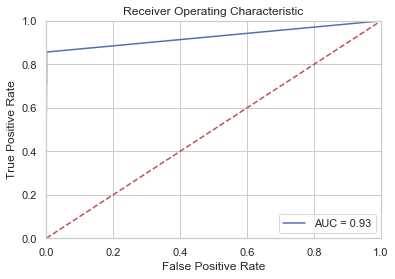

In [27]:
from sklearn import metrics
probs = model1.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

- For model2

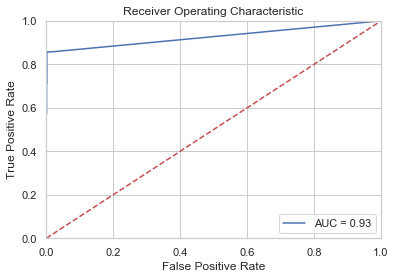

In [28]:
from sklearn import metrics
probs = model2.predict_proba(X_test)
pred = probs[:,1]
fpr1, tpr1, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr1, tpr1)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Comparing the ROC-AUC curve for both the models, observing that there is __no significant difference__ between the two plots. 

<a id = section5.7></a>

### 5.7 Choosing better model using recall score

We have compared the performance of the two models using various model evaluation techinques.<br/>
Our objective is to __minimize False Negative__ as missing a lot of fradulent transactions is worse than predicting “fraud” on non fraudulent transactions, <br/>as more enquiry will be done on them in further steps. Therefore, among recall & precision scores, we will give more importance to __recall score__.

- Recall score for model1 is: __0.71__
- Recall score for model2 is: __0.57__

As recall score of model1 is __better__ than that of model2, hence for predicting fradulent transaction __model1 is preferable.__